### Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import igraph
import seaborn as sns
import scipy
import itertools
from joblib import Parallel, delayed
from igraph import GraphBase
from itertools import combinations
from pylab import *
from scipy.ndimage import measurements 

### Class

In [2]:
# Define Class
class NetworkMetrics():
    def __init__(self,
                network,
                function):
        
        self.network = network
        self.function = function
                  
    def calcFunc(self): 
        func = eval("GraphBase." + self.function)(self.network)
        return func
           
    def measure(self):
        print(self.calcFunc())

### Initialization

In [3]:
# Load Zachary's karate club network
g = igraph.Graph.Famous('zachary')

In [4]:
# Set the number of rewirings and simulations
rewirings = list(np.arange(0, 101, 2))
simulations = 250 #Equal for shuffles

### Functions

In [5]:
#Define functions
def triangles(g):
    cliques = GraphBase.cliques(g,min=3, max=3)
    result = [0] * GraphBase.vcount(g)
    for i, j, k in cliques:
        result[i] += 1
        result[j] += 1
        result[k] += 1
    return result

#Define functions for Shuffle
def create_statsfile_shuffle(name):
    with open("../data/"+name+"/stats_"+name+"_metrics.csv", "w") as outfile_shuffle:
        outfile_shuffle.write("simulations,Assortativity coefficient,Q25ac,Q75ac,p-value assortativity,Average Betweenness,Q25abet,Q75abet,p-value betweenness distribution,Average Closeness,Q25aclo,Q75aclo,p-value closeness distribution,Number of triangles,Q25numtri,Q75numtri,p-value num triangles,Average triangles formed by an edge,Q25avgtri,Q75avgtri,p-value avg triangles,Average local clustering coefficient,Q25tr,Q75tr,p-value transitivity,Global clustering coefficient,Q25clu,Q75clu,p-value global clustering,Average local path length,Q25apl,Q75apl,p-value avg path length,Percolation treshold,Q25perc,Q75perc,p-value percolation\n")

def NetworkMetrics_calc_shuffle(g, simulations, file, name):
    g_copy = GraphBase.copy(g) 
    triangles_all = np.zeros((simulations, GraphBase.vcount(g_copy)))
    betweenness = np.zeros((simulations, GraphBase.vcount(g_copy)))
    closeness = np.zeros((simulations, GraphBase.vcount(g_copy)))
    assortativity = np.zeros(simulations)
    betweenness_avg = np.zeros(simulations)
    closeness_avg = np.zeros(simulations)
    triangles_num = np.zeros(simulations)
    triangles_avg = np.zeros(simulations)
    local_clustering = np.zeros(simulations)
    global_clustering = np.zeros(simulations)
    avg_path_len = np.zeros(simulations)
    for sim in range(simulations):
        g_shuffle = GraphBase.copy(g).get_adjacency()
        g_shuffle = np.array(list(g_shuffle))
        np.random.shuffle(g_shuffle)
        g_shuffle = igraph.Graph.Adjacency((g_shuffle > 0).tolist())
        triangles_all[sim,:] = np.array(triangles(g_shuffle))
        betweenness[sim,:] = np.array(NetworkMetrics(g_shuffle, 'betweenness').calcFunc())
        closeness[sim,:] = np.array(NetworkMetrics(g_shuffle, 'closeness').calcFunc())
        assortativity[sim] = NetworkMetrics(g_shuffle, 'assortativity_degree').calcFunc()  
        betweenness_avg[sim] = betweenness[sim,:].mean() 
        closeness_avg[sim] = np.nanmean(closeness[sim,:]) 
        triangles_num[sim] = len(NetworkMetrics(g_shuffle, 'list_triangles').calcFunc())
        triangles_avg[sim] = np.array(triangles(g_shuffle)).mean()
        local_clustering[sim] = NetworkMetrics(g_shuffle, 'transitivity_avglocal_undirected').calcFunc()
        global_clustering[sim] = NetworkMetrics(g_shuffle, 'transitivity_undirected').calcFunc()
        avg_path_len[sim] = np.array(NetworkMetrics(g_shuffle, 'average_path_length').calcFunc()).max()

    #output data
    with open(file, 'a+') as outfile_shuffle:
        outfile_shuffle.write(str(250) + "," + #simulations
                      #Assortativity
                      str(np.mean(assortativity)) + "," +
                      str(np.quantile(assortativity, 0.25)) + "," +
                      str(np.quantile(assortativity, 0.75)) + "," +
                      str(scipy.stats.wilcoxon(assortativity, np.repeat(assortativity[0],simulations), zero_method = 'zsplit')[1])+ "," + #p-value
                      #Avg betweenness
                      str(np.mean(betweenness_avg)) + "," +
                      str(np.quantile(betweenness_avg, 0.25)) + "," +
                      str(np.quantile(betweenness_avg, 0.75)) + "," +
                      str(scipy.stats.wilcoxon(betweenness_avg, np.repeat(betweenness_avg[0],simulations), zero_method = 'zsplit')[1])+ "," + #p-value
                      #Avg closeness
                      str(np.mean(closeness_avg)) + "," +
                      str(np.quantile(closeness_avg, 0.25)) + "," +
                      str(np.quantile(closeness_avg, 0.75)) + "," +
                      str(scipy.stats.wilcoxon(closeness_avg, np.repeat(closeness_avg[0],simulations), zero_method = 'zsplit')[1])+ "," + #p-value                   
                      #Number of Triangles
                      str(np.mean(triangles_num)) + "," +
                      str(np.quantile(triangles_num, 0.25)) + "," +
                      str(np.quantile(triangles_num, 0.75)) + "," + 
                      str(scipy.stats.wilcoxon(triangles_num, np.repeat(triangles_num[0],simulations), zero_method = 'zsplit')[1])+ "," + #p-value
                      #Average of Triangles
                      str(np.mean(triangles_avg)) + "," +
                      str(np.quantile(triangles_avg, 0.25)) + "," +
                      str(np.quantile(triangles_avg, 0.75)) + "," + 
                      str(scipy.stats.wilcoxon(triangles_avg, np.repeat(triangles_avg[0],simulations), zero_method = 'zsplit')[1])+ "," + #p-value
                      #Average Local Clustering
                      str(np.mean(local_clustering)) + "," +
                      str(np.quantile(local_clustering, 0.25)) + "," +
                      str(np.quantile(local_clustering, 0.75)) + "," + 
                      str(scipy.stats.wilcoxon(local_clustering, np.repeat(local_clustering[0],simulations), zero_method = 'zsplit')[1])+ "," + #p-value
                      #Global Clustreing
                      str(np.mean(global_clustering)) + "," +
                      str(np.quantile(global_clustering, 0.25)) + "," +
                      str(np.quantile(global_clustering, 0.75)) + "," + 
                      str(scipy.stats.wilcoxon(global_clustering, np.repeat(global_clustering[0],simulations), zero_method = 'zsplit')[1])+ "," + #p-value
                      #Average Path Length
                      str(np.mean(avg_path_len)) + "," +
                      str(np.quantile(avg_path_len, 0.25)) + "," +
                      str(np.quantile(avg_path_len, 0.75)) + "," + 
                      str(scipy.stats.wilcoxon(avg_path_len, np.repeat(avg_path_len[0],simulations), zero_method = 'zsplit')[1])+ "\n") #p-value

    np.savez_compressed("../data/"+name+"/stats_"+name+"_"+str(simulations)+"_"+"_triangles.npz", triangles_all)
    np.savez_compressed("../data/"+name+"/stats_"+name+"_"+str(simulations)+"_"+"_betweenness.npz", betweenness)
    np.savez_compressed("../data/"+name+"/stats_"+name+"_"+str(simulations)+"_"+"_closeness.npz", closeness)

#Define functions for Rewire    
def create_statsfile_rewire(g, name):
    with open("../data/"+name+"/stats_"+name+"_metrics.csv", "w") as outfile:
        outfile.write("rewirings,Assortativity coefficient,Q25ac,Q75ac,p-value assortativity,Average Betweenness,Q25abet,Q75abet,p-value betweenness distribution,Average Closeness,Q25aclo,Q75aclo,p-value closeness distribution,Number of triangles,Q25numtri,Q75numtri,p-value num triangles,Average triangles formed by an edge,Q25avgtri,Q75avgtri,p-value avg triangles,Average local clustering coefficient,Q25tr,Q75tr,p-value transitivity,Global clustering coefficient,Q25clu,Q75clu,p-value global clustering,Average local path length,Q25apl,Q75apl,p-value avg path length,Percolation treshold,Q25perc,Q75perc,p-value percolation\n")

def NetworkMetrics_calc_rewire(g, count, rews, simulations, file, name):
    g_copy = GraphBase.copy(g) 
    triangles_all = np.zeros((simulations, GraphBase.vcount(g_copy)))
    betweenness = np.zeros((simulations, GraphBase.vcount(g_copy)))
    closeness = np.zeros((simulations, GraphBase.vcount(g_copy)))
    assortativity = np.zeros(simulations)
    betweenness_avg = np.zeros(simulations)
    closeness_avg = np.zeros(simulations)
    triangles_num = np.zeros(simulations)
    triangles_avg = np.zeros(simulations)
    local_clustering = np.zeros(simulations)
    global_clustering = np.zeros(simulations)
    avg_path_len = np.zeros(simulations)
    for sim in range(simulations):
        GraphBase.rewire(g_copy, n=rews)
        triangles_all[sim,:] = np.array(triangles(g_copy))
        betweenness[sim,:] = np.array(NetworkMetrics(g_copy, 'betweenness').calcFunc())
        closeness[sim,:] = np.array(NetworkMetrics(g_copy, 'closeness').calcFunc())
        assortativity[sim] = NetworkMetrics(g_copy, 'assortativity_degree').calcFunc()  
        betweenness_avg[sim] = betweenness[sim,:].mean() 
        closeness_avg[sim] = np.nanmean(closeness[sim,:]) 
        triangles_num[sim] = len(NetworkMetrics(g_copy, 'list_triangles').calcFunc())
        triangles_avg[sim] = np.array(triangles(g_copy)).mean()
        local_clustering[sim] = NetworkMetrics(g_copy, 'transitivity_avglocal_undirected').calcFunc()
        global_clustering[sim] = NetworkMetrics(g_copy, 'transitivity_undirected').calcFunc()
        avg_path_len[sim] = np.array(NetworkMetrics(g_copy, 'average_path_length').calcFunc()).max()

    #output data
    with open(file, 'a+') as outfile:
        outfile.write(str(rews) + "," + #rewirings
                      #Assortativity
                      str(np.mean(assortativity)) + "," +
                      str(np.quantile(assortativity, 0.25)) + "," +
                      str(np.quantile(assortativity, 0.75)) + "," +
                      str(scipy.stats.wilcoxon(assortativity, np.repeat(assortativity[0],simulations), zero_method = 'zsplit')[1])+ "," + #p-value
                      #Avg betweenness
                      str(np.mean(betweenness_avg)) + "," +
                      str(np.quantile(betweenness_avg, 0.25)) + "," +
                      str(np.quantile(betweenness_avg, 0.75)) + "," +
                      str(scipy.stats.wilcoxon(betweenness_avg, np.repeat(betweenness_avg[0],simulations), zero_method = 'zsplit')[1])+ "," + #p-value
                      #Avg closeness
                      str(np.mean(closeness_avg)) + "," +
                      str(np.quantile(closeness_avg, 0.25)) + "," +
                      str(np.quantile(closeness_avg, 0.75)) + "," +
                      str(scipy.stats.wilcoxon(closeness_avg, np.repeat(closeness_avg[0],simulations), zero_method = 'zsplit')[1])+ "," + #p-value                   
                      #Number of Triangles
                      str(np.mean(triangles_num)) + "," +
                      str(np.quantile(triangles_num, 0.25)) + "," +
                      str(np.quantile(triangles_num, 0.75)) + "," + 
                      str(scipy.stats.wilcoxon(triangles_num, np.repeat(triangles_num[0],simulations), zero_method = 'zsplit')[1])+ "," + #p-value
                      #Average of Triangles
                      str(np.mean(triangles_avg)) + "," +
                      str(np.quantile(triangles_avg, 0.25)) + "," +
                      str(np.quantile(triangles_avg, 0.75)) + "," + 
                      str(scipy.stats.wilcoxon(triangles_avg, np.repeat(triangles_avg[0],simulations), zero_method = 'zsplit')[1])+ "," + #p-value
                      #Average Local Clustering
                      str(np.mean(local_clustering)) + "," +
                      str(np.quantile(local_clustering, 0.25)) + "," +
                      str(np.quantile(local_clustering, 0.75)) + "," + 
                      str(scipy.stats.wilcoxon(local_clustering, np.repeat(local_clustering[0],simulations), zero_method = 'zsplit')[1])+ "," + #p-value
                      #Global Clustreing
                      str(np.mean(global_clustering)) + "," +
                      str(np.quantile(global_clustering, 0.25)) + "," +
                      str(np.quantile(global_clustering, 0.75)) + "," + 
                      str(scipy.stats.wilcoxon(global_clustering, np.repeat(global_clustering[0],simulations), zero_method = 'zsplit')[1])+ "," + #p-value
                      #Average Path Length
                      str(np.mean(avg_path_len)) + "," +
                      str(np.quantile(avg_path_len, 0.25)) + "," +
                      str(np.quantile(avg_path_len, 0.75)) + "," + 
                      str(scipy.stats.wilcoxon(avg_path_len, np.repeat(avg_path_len[0],simulations), zero_method = 'zsplit')[1])+ "\n") #p-value

    np.savez_compressed("../data/"+name+"/stats_"+name+"_"+str(rews)+"_"+"_triangles.npz", triangles_all)
    np.savez_compressed("../data/"+name+"/stats_"+name+"_"+str(rews)+"_"+"_betweenness.npz", betweenness)
    np.savez_compressed("../data/"+name+"/stats_"+name+"_"+str(rews)+"_"+"_closeness.npz", closeness)

#Define function for Plotting    
def PanelPlot(name, simulations, rewirings, label_here):
    fig, ((ax1, ax2, ax3, ax4),
          (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(16, 6), sharey=False)

    sns.set()
    sns.set_style("whitegrid", {'axes.grid' : False})
    
    x_max = max(rewirings)
    df = pd.read_csv("../data/"+name+"/stats_"+name+"_metrics.csv", sep = ',')
    df = df.sort_values(by = 'rewirings')
    df = df.reset_index(drop=True)
    df2 = pd.read_csv("../data/"+name+"_shuffle/stats_"+name+"_shuffle_metrics.csv", sep = ',')

    ax1.x = df["rewirings"]
    ax1.mean_1 = np.repeat(df["Assortativity coefficient"][0],len(rewirings))
    ax1.mean_2 = df["Assortativity coefficient"]
    ax1.mean_3 = np.repeat(df2["Assortativity coefficient"][0],len(rewirings))
    ax1.std_inf = abs(df["Assortativity coefficient"]-df["Q25ac"].array)
    ax1.std_sup = abs(df["Assortativity coefficient"]-df["Q75ac"].array)
    ax1.shuf_inf = np.repeat(abs(df2["Assortativity coefficient"][0]-df2["Q25ac"][0]),len(rewirings))
    ax1.shuf_sup = np.repeat(abs(df2["Assortativity coefficient"][0]-df2["Q75ac"][0]),len(rewirings))
    ax1.set(xlim=(0, x_max))
    ax1.plot(ax1.x, ax1.mean_1, 'b-', label=label_here)
    ax1.fill_between(ax1.x, ax1.mean_1, ax1.mean_1, color='b', alpha=0.2)
    ax1.plot(ax1.x, ax1.mean_2, 'r--', label= str(simulations)+' simulations')
    ax1.fill_between(ax1.x, ax1.mean_2 - ax1.std_inf, ax1.mean_2 + ax1.std_sup, color='r', alpha=0.2)
    ax1.plot(ax1.x, ax1.mean_3, 'g--', label= str(simulations)+' shuffles')
    ax1.fill_between(ax1.x, ax1.mean_3 - ax1.shuf_inf, ax1.mean_3 + ax1.shuf_sup, color='g', alpha=0.2)
    ax1.labs = [item.get_text() for item in ax1.get_yticklabels()]
    ax1.set_yticks(np.unique(np.array(list([round(float(b.replace('−', '-')), 2) for b in ax1.labs]))).tolist())
    ax1.set_title('Assortativity', fontsize=12)

    ax2.x = df["rewirings"]
    ax2.mean_1 = np.repeat(df["Average Betweenness"][0],len(rewirings))
    ax2.mean_2 = df["Average Betweenness"]
    ax2.mean_3 = np.repeat(df2["Average Betweenness"][0],len(rewirings))
    ax2.std_inf = abs(df["Average Betweenness"]-df["Q25abet"].array)
    ax2.std_sup = abs(df["Average Betweenness"]-df["Q75abet"].array)
    ax2.shuf_inf = np.repeat(abs(df2["Average Betweenness"][0]-df2["Q25abet"][0]),len(rewirings))
    ax2.shuf_sup = np.repeat(abs(df2["Average Betweenness"][0]-df2["Q75abet"][0]),len(rewirings))
    ax2.set(xlim=(0, x_max))
    ax2.plot(ax2.x, ax2.mean_1, 'b-', label=label_here)
    ax2.fill_between(ax2.x, ax2.mean_1, ax2.mean_1, color='b', alpha=0.2)
    ax2.plot(ax2.x, ax2.mean_2, 'r--', label= str(simulations)+' simulations')
    ax2.fill_between(ax2.x, ax2.mean_2 - ax2.std_inf, ax2.mean_2 + ax2.std_sup, color='r', alpha=0.2)
    ax2.plot(ax2.x, ax2.mean_3, 'g--', label= str(simulations)+' shuffles')
    ax2.fill_between(ax2.x, ax2.mean_3 - ax2.shuf_inf, ax2.mean_3 + ax2.shuf_sup, color='g', alpha=0.2)
    ax2.labs = [item.get_text() for item in ax2.get_yticklabels()]
    ax2.set_yticks(np.unique(np.array(list([round(float(b.replace('−', '-')), 2) for b in ax2.labs]))).tolist())
    ax2.set_title('Average Betweenness', fontsize=12)

    ax3.x = df["rewirings"]
    ax3.mean_1 = np.repeat(df["Average Closeness"][0],len(rewirings))
    ax3.mean_2 = df["Average Closeness"]
    ax3.mean_3 = np.repeat(df2["Average Closeness"][0],len(rewirings))
    ax3.std_inf = abs(df["Average Closeness"]-df["Q25aclo"].array)
    ax3.std_sup = abs(df["Average Closeness"]-df["Q75aclo"].array)
    ax3.shuf_inf = np.repeat(abs(df2["Average Closeness"][0]-df2["Q25aclo"][0]),len(rewirings))
    ax3.shuf_sup = np.repeat(abs(df2["Average Closeness"][0]-df2["Q75aclo"][0]),len(rewirings))
    ax3.set(xlim=(0, x_max))
    ax3.plot(ax3.x, ax3.mean_1, 'b-', label=label_here)
    ax3.fill_between(ax3.x, ax3.mean_1, ax3.mean_1, color='b', alpha=0.2)
    ax3.plot(ax3.x, ax3.mean_2, 'r--', label= str(simulations)+' simulations')
    ax3.fill_between(ax3.x, ax3.mean_2 - ax3.std_inf, ax3.mean_2 + ax3.std_sup, color='r', alpha=0.2)
    ax3.plot(ax3.x, ax3.mean_3, 'g--', label= str(simulations)+' shuffles')
    ax3.fill_between(ax3.x, ax3.mean_3 - ax3.shuf_inf, ax3.mean_3 + ax3.shuf_sup, color='g', alpha=0.2)
    ax3.labs = [item.get_text() for item in ax3.get_yticklabels()]
    ax3.set_yticks(np.unique(np.array(list([round(float(b.replace('−', '-')), 2) for b in ax3.labs]))).tolist())
    ax3.set_title('Average Closeness', fontsize=12)

    ax4.x = df["rewirings"]
    ax4.mean_1 = np.repeat(df["Average local path length"][0],len(rewirings))
    ax4.mean_2 = df["Average local path length"]
    ax4.mean_3 = np.repeat(df2["Average local path length"][0],len(rewirings))
    ax4.std_inf = abs(df["Average local path length"]-df["Q25apl"].array)
    ax4.std_sup = abs(df["Average local path length"]-df["Q75apl"].array)
    ax4.shuf_inf = np.repeat(abs(df2["Average local path length"][0]-df2["Q25apl"][0]),len(rewirings))
    ax4.shuf_sup = np.repeat(abs(df2["Average local path length"][0]-df2["Q75apl"][0]),len(rewirings))
    ax4.set(xlim=(0, x_max))
    ax4.plot(ax4.x, ax4.mean_1, 'b-', label=label_here)
    ax4.fill_between(ax4.x, ax4.mean_1, ax4.mean_1, color='b', alpha=0.2)
    ax4.plot(ax4.x, ax4.mean_2, 'r--', label= str(simulations)+' simulations')
    ax4.fill_between(ax4.x, ax4.mean_2 - ax4.std_inf, ax4.mean_2 + ax4.std_sup, color='r', alpha=0.2)
    ax4.plot(ax4.x, ax4.mean_3, 'g--', label= str(simulations)+' shuffles')
    ax4.fill_between(ax4.x, ax4.mean_3 - ax4.shuf_inf, ax4.mean_3 + ax4.shuf_sup, color='g', alpha=0.2)
    ax4.labs = [item.get_text() for item in ax4.get_yticklabels()]
    ax4.set_yticks(np.unique(np.array(list([round(float(b.replace('−', '-')), 2) for b in ax4.labs]))).tolist())
    ax4.set_title('Average Local Path Length', fontsize=12)

    ax5.x = df["rewirings"]
    ax5.mean_1 = np.repeat(df["Number of triangles"][0],len(rewirings))
    ax5.mean_2 = df["Number of triangles"]
    ax5.mean_3 = np.repeat(df2["Number of triangles"][0],len(rewirings))
    ax5.std_inf = abs(df["Number of triangles"]-df["Q25numtri"].array)
    ax5.std_sup = abs(df["Number of triangles"]-df["Q75numtri"].array)
    ax5.shuf_inf = np.repeat(abs(df2["Number of triangles"][0]-df2["Q25numtri"][0]),len(rewirings))
    ax5.shuf_sup = np.repeat(abs(df2["Number of triangles"][0]-df2["Q75numtri"][0]),len(rewirings))
    ax5.set(xlim=(0, x_max))
    ax5.plot(ax5.x, ax5.mean_1, 'b-', label=label_here)
    ax5.fill_between(ax5.x, ax5.mean_1, ax5.mean_1, color='b', alpha=0.2)
    ax5.plot(ax5.x, ax5.mean_2, 'r--', label= str(simulations)+' simulations')
    ax5.fill_between(ax5.x, ax5.mean_2 - ax5.std_inf, ax5.mean_2 + ax5.std_sup, color='r', alpha=0.2)
    ax5.plot(ax5.x, ax5.mean_3, 'g--', label= str(simulations)+' shuffles')
    ax5.fill_between(ax5.x, ax5.mean_3 - ax5.shuf_inf, ax5.mean_3 + ax5.shuf_sup, color='g', alpha=0.2)
    ax5.labs = [item.get_text() for item in ax5.get_yticklabels()]
    ax5.set_yticks(np.unique(np.array(list([round(float(b.replace('−', '-')), 2) for b in ax5.labs]))).tolist())
    ax5.set_title('Number of Triangles', fontsize=12)

    ax6.x = df["rewirings"]
    ax6.mean_1 = np.repeat(df["Average triangles formed by an edge"][0],len(rewirings))
    ax6.mean_2 = df["Average triangles formed by an edge"]
    ax6.mean_3 = np.repeat(df2["Average triangles formed by an edge"][0],len(rewirings))
    ax6.std_inf = abs(df["Average triangles formed by an edge"]-df["Q25avgtri"].array)
    ax6.std_sup = abs(df["Average triangles formed by an edge"]-df["Q75avgtri"].array)
    ax6.shuf_inf = np.repeat(abs(df2["Average triangles formed by an edge"][0]-df2["Q25avgtri"][0]),len(rewirings))
    ax6.shuf_sup = np.repeat(abs(df2["Average triangles formed by an edge"][0]-df2["Q75avgtri"][0]),len(rewirings))
    ax6.set(xlim=(0, x_max))
    ax6.plot(ax6.x, ax6.mean_1, 'b-', label=label_here)
    ax6.fill_between(ax6.x, ax6.mean_1, ax6.mean_1, color='b', alpha=0.2)
    ax6.plot(ax6.x, ax6.mean_2, 'r--', label= str(simulations)+' simulations')
    ax6.fill_between(ax6.x, ax6.mean_2 - ax6.std_inf, ax6.mean_2 + ax6.std_sup, color='r', alpha=0.2)
    ax6.plot(ax6.x, ax6.mean_3, 'g--', label= str(simulations)+' shuffles')
    ax6.fill_between(ax6.x, ax6.mean_3 - ax6.shuf_inf, ax6.mean_3 + ax6.shuf_sup, color='g', alpha=0.2)
    ax6.labs = [item.get_text() for item in ax6.get_yticklabels()]
    ax6.set_yticks(np.unique(np.array(list([round(float(b.replace('−', '-')), 2) for b in ax6.labs]))).tolist())
    ax6.set_title('Average of Triangles by Edge', fontsize=12)

    ax7.x = df["rewirings"]
    ax7.mean_1 = np.repeat(df["Average local clustering coefficient"][0],len(rewirings))
    ax7.mean_2 = df["Average local clustering coefficient"]
    ax7.mean_3 = np.repeat(df2["Average local clustering coefficient"][0],len(rewirings))
    ax7.std_inf = abs(df["Average local clustering coefficient"]-df["Q25tr"].array)
    ax7.std_sup = abs(df["Average local clustering coefficient"]-df["Q75tr"].array)
    ax7.shuf_inf = np.repeat(abs(df2["Average local clustering coefficient"][0]-df2["Q25tr"][0]),len(rewirings))
    ax7.shuf_sup = np.repeat(abs(df2["Average local clustering coefficient"][0]-df2["Q75tr"][0]),len(rewirings))
    ax7.set(xlim=(0, x_max))
    ax7.plot(ax7.x, ax7.mean_1, 'b-', label=label_here)
    ax7.fill_between(ax7.x, ax7.mean_1, ax7.mean_1, color='b', alpha=0.2)
    ax7.plot(ax7.x, ax7.mean_2, 'r--', label= str(simulations)+' simulations')
    ax7.fill_between(ax7.x, ax7.mean_2 - ax7.std_inf, ax7.mean_2 + ax7.std_sup, color='r', alpha=0.2)
    ax7.plot(ax7.x, ax7.mean_3, 'g--', label= str(simulations)+' shuffles')
    ax7.fill_between(ax7.x, ax7.mean_3 - ax7.shuf_inf, ax7.mean_3 + ax7.shuf_sup, color='g', alpha=0.2)
    ax7.labs = [item.get_text() for item in ax7.get_yticklabels()]
    ax7.set_yticks(np.unique(np.array(list([round(float(b.replace('−', '-')), 2) for b in ax7.labs]))).tolist())
    ax7.set_title('Average Local Clustering', fontsize=12)

    ax8.x = df["rewirings"]
    ax8.mean_1 = np.repeat(df["Global clustering coefficient"][0],len(rewirings))
    ax8.mean_2 = df["Global clustering coefficient"]
    ax8.mean_3 = np.repeat(df2["Global clustering coefficient"][0],len(rewirings))
    ax8.std_inf = abs(df["Global clustering coefficient"]-df["Q25clu"].array)
    ax8.std_sup = abs(df["Global clustering coefficient"]-df["Q75clu"].array)
    ax8.shuf_inf = np.repeat(abs(df2["Global clustering coefficient"][0]-df2["Q25clu"][0]),len(rewirings))
    ax8.shuf_sup = np.repeat(abs(df2["Global clustering coefficient"][0]-df2["Q75clu"][0]),len(rewirings))
    ax8.set(xlim=(0, x_max))
    ax8.plot(ax8.x, ax8.mean_1, 'b-', label=label_here)
    ax8.fill_between(ax8.x, ax8.mean_1, ax8.mean_1, color='b', alpha=0.2)
    ax8.plot(ax8.x, ax8.mean_2, 'r--', label= str(simulations)+' simulations')
    ax8.fill_between(ax8.x, ax8.mean_2 - ax8.std_inf, ax8.mean_2 + ax8.std_sup, color='r', alpha=0.2)
    ax8.plot(ax8.x, ax8.mean_3, 'g--', label= str(simulations)+' shuffles')
    ax8.fill_between(ax8.x, ax8.mean_3 - ax8.shuf_inf, ax8.mean_3 + ax8.shuf_sup, color='g', alpha=0.2)
    ax8.labs = [item.get_text() for item in ax8.get_yticklabels()]
    ax8.set_yticks(np.unique(np.array(list([round(float(b.replace('−', '-')), 2) for b in ax8.labs]))).tolist())
    ax8.set_title('Global Clustering', fontsize=12)
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=12)
    fig.tight_layout()

    plt.savefig("../plots/"+name+"_metrics.pdf")
    plt.show()

### Simulations

In [6]:
#Run the simulations for Rewirings
name = 'results'
create_statsfile_rewire(g, name = name)
Parallel(n_jobs=22)(delayed(NetworkMetrics_calc_rewire)(g.copy(), count, rews, simulations, "../data/"+name+"/stats_"+name+"_metrics.csv", name) for count, rews in enumerate(rewirings))

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [7]:
#Run the simulations for Shuffles
name = 'results_shuffle' # Keep it as #name_shuffles
create_statsfile_shuffle(name = name)
NetworkMetrics_calc_shuffle(g.copy(), simulations, file = "../data/"+name+"/stats_"+name+"_metrics.csv", name = name)

/tmp/ipykernel_580181/2627028755.py:3: RuntimeWarning: Edge directions are ignored for clique calculations at src/cliques/cliquer_wrapper.c:24
  cliques = GraphBase.cliques(g,min=3, max=3)


### Plotting

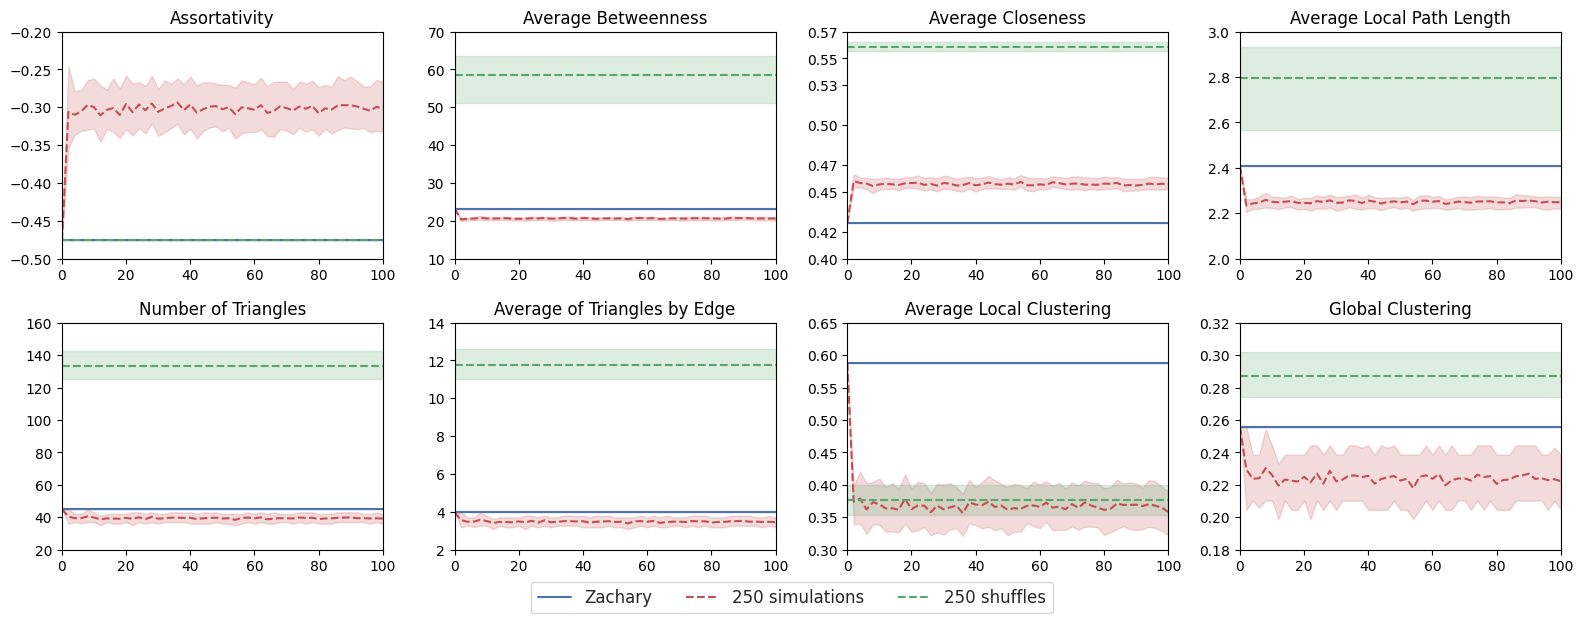

In [8]:
#Plot the charts
label_here = str('Zachary')
name = 'results'
PanelPlot(name, simulations, rewirings, label_here)